In [1]:
from urllib.request import urlopen
from IPython.display import SVG
import matplotlib.pyplot as plt
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import xlsxwriter
import argparse
import pickle
import numpy as np
import json

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import visualizer as visualizer
import utils as utils
import handle_network as hn
import fragmentation_py as fragmentation_py
import library_downloader as library_downloader
import Compound_n as Compound_n
import ModificationSiteLocator as modSite

import math
import multiprocessing as mp
from multiprocessing import Pool

In [2]:

libraries = {
    "GNPS-MSMLS": "https://external.gnps2.org/gnpslibrary/GNPS-MSMLS.json",
    "GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE": "https://external.gnps2.org/gnpslibrary/GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE.json",
    "GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE": "https://external.gnps2.org/gnpslibrary/GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE.json",
    "MIADB": "https://external.gnps2.org/gnpslibrary/MIADB.json",
    "BERKELEY-LAB": "https://external.gnps2.org/gnpslibrary/BERKELEY-LAB.json"
    # "GNPS-LIBRARY": "https://gnps-external.ucsd.edu/gnpslibrary/GNPS-LIBRARY.json"
}

library ="BERKELEY-LAB"
if not os.path.exists( os.path.join("../data/libraries", library)):
    url = "https://gnps-external.ucsd.edu/gnpslibrary/" + library + ".json"
    location = "../data/libraries/" + library + "/"
    library_downloader.download(url, location, 0.5, 0.1)

with open(os.path.join("../data/libraries", library, "data_dict_filtered.pkl"), "rb") as f:
    data_dict_filtered = pickle.load(f)

# load matches
with open(os.path.join("../data/libraries", library, "matches.pkl"), "rb") as f:
    matches = pickle.load(f)

# load cachedStructures_filtered
with open(os.path.join("../data/libraries", library, "cachedStructures.pkl"), "rb") as f:
    cachedStructures_filtered = pickle.load(f)

helperDirectory = os.path.join("../data/libraries",library,"nf_output/fragmentationtrees/")
helpers = dict()

filter_matches = []
for match in matches[1]:
    if data_dict_filtered[match[0]]["Adduct"]!= "M+H" or "M+H" not in data_dict_filtered[match[1]]["Adduct"] or data_dict_filtered[match[0]]["Adduct"] != data_dict_filtered[match[1]]["Adduct"]:
        continue
    filter_matches.append(match)

for match in filter_matches:
    if match[0] not in helpers:
        helpers[match[0]] = []
    helpers[match[0]].append(match[1])

In [3]:
print(len(helpers), len(filter_matches))

2496 9967


In [15]:
def calculate_score(m0, m1):
    mainStructure = cachedStructures_filtered[m1]
    modifiedStructure = cachedStructures_filtered[m0]
    main_compound = Compound_n.Compound(data_dict_filtered[m1], mainStructure, {"filter_peaks_method": "None"})
    modified_compound = Compound_n.Compound(data_dict_filtered[m0], modifiedStructure, {"filter_peaks_method": "None"})
    site_locator = modSite.ModificationSiteLocator(main_compound, modified_compound)

    s_peakids = [_[0] for _ in site_locator.shifted]
    print(s_peakids, site_locator.matched_peaks, site_locator.cosine)
    print("map", site_locator.main_compound.peak_fragments_map)
    print("calculate_contributions:", site_locator.calculate_contributions(s_peakids, PPO=True))
    
    
    probab = site_locator.generate_probabilities(shifted_only = True, PPO = True, CO = False, true_modification_site = None)
    modifLoc = utils.calculateModificationSites(modifiedStructure, mainStructure, False)[0]
    score = site_locator.calculate_score(modifLoc, "is_max", probab)
    print(probab)
    return score



[60, 21, 36, 44, 49, 52, 55, 25, 27, 57, 54, 42, 40, 39, 46, 41, 9, 32, 26, 33, 24, 12, 2, 59, 30, 48, 38] [(60, 106), (21, 34), (36, 68), (44, 83), (22, 25), (49, 91), (52, 93), (55, 100), (31, 45), (25, 46), (27, 50), (57, 101), (54, 99), (42, 81), (8, 4), (29, 44), (37, 57), (40, 77), (13, 9), (39, 72), (14, 10), (20, 22), (34, 51), (46, 87), (41, 79), (9, 13), (28, 39), (56, 95), (53, 89), (3, 2), (32, 62), (26, 49), (19, 21), (33, 63), (24, 40), (35, 56), (12, 15), (2, 5), (59, 105), (23, 26), (43, 70), (30, 55), (48, 88), (58, 102), (11, 6), (15, 12), (38, 69)] 0.9565420741038851
map [set(), {960, 480}, {960, 480, 110592, 61440, 237568, 188416}, {960, 480, 110592, 61440, 237568, 188416}, {122880, 110592, 61440, 188416, 237568}, {122880, 110592, 61440, 188416, 237568}, {122880}, {122880}, set(), set(), {126976, 253952}, {126976, 253952, 440320}, {1008, 440320}, {1008, 440320}, set(), set(), set(), {1016, 505856, 456704, 441344}, {505856, 456704, 441344}, set(), {2040, 440323, 1020

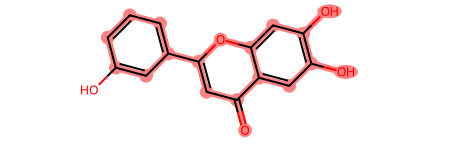

In [24]:
i = np.random.randint(0, len(filter_matches))
#i = 394
usi1 = "mzspec:GNPS:" + library + ":accession:" + filter_matches[0][0]
usi2 = "mzspec:GNPS:" + library + ":accession:" + filter_matches[0][1]
smiles1 = data_dict_filtered[filter_matches[i][0]]["Smiles"]
smiles2 = data_dict_filtered[filter_matches[i][1]]["Smiles"]
# print(usi1, usi2, smiles1, smiles2)
s = calculate_score(filter_matches[i][0], filter_matches[i][1])
m0, m1 = filter_matches[i]
mainStructure = cachedStructures_filtered[m1]
modifiedStructure = cachedStructures_filtered[m0]
main_compound = Compound_n.Compound(data_dict_filtered[m1], mainStructure, {"filter_peaks_method": "None"})
modified_compound = Compound_n.Compound(data_dict_filtered[m0], modifiedStructure, {"filter_peaks_method": "None"})
modifiedStructure.HasSubstructMatch(mainStructure)
print("SCORE", s)
modifiedStructure

In [6]:

import handle_network as hn
hn.getMatchedPeaks(usi1, usi2)

{'cosine': 0.9470074746759565,
 'n_peak_matches': 21,
 'peak_matches': [[73, 23],
  [65, 19],
  [43, 10],
  [63, 17],
  [50, 20],
  [70, 22],
  [60, 14],
  [56, 12],
  [61, 15],
  [51, 11],
  [15, 9],
  [28, 6],
  [77, 24],
  [37, 7],
  [41, 8],
  [5, 3],
  [64, 18],
  [35, 16],
  [69, 21],
  [8, 4],
  [9, 5]],
 'spectrum1': {'n_peaks': 80,
  'peaks': [[53.93949890136719, 3523.0],
   [55.01836013793945, 11475.0],
   [57.07044982910156, 3041.0],
   [58.96086883544922, 22192.0],
   [61.010990142822266, 40874.0],
   [74.02393341064453, 19830.0],
   [79.02139282226562, 40853.0],
   [82.39507293701172, 3063.0],
   [91.05449676513672, 5371.0],
   [92.37049102783203, 3614.0],
   [99.98697662353516, 10127.0],
   [103.05402374267578, 6713.0],
   [104.28170776367188, 2901.0],
   [115.0539779663086, 28510.0],
   [116.04915618896484, 22810.0],
   [117.05711364746094, 71420.0],
   [117.06926727294922, 30326.0],
   [117.99736785888672, 3752.0],
   [118.06529235839844, 19299.0],
   [121.0650634765625